In [1]:
##################################### LOAD packages ############################
import pandas as pd
import numpy as np
from sklearn import preprocessing                                 #scale/normalize data
import matplotlib.pyplot as plt                                   #plot graphs from scratch
import seaborn as sns                                             #function to see correlation between features
import scipy.stats as stats                                       #qq plot       
import pylab
from sklearn.linear_model import LinearRegression, Ridge          #for our base model, ridge regression
from sklearn.feature_selection import RFE                         #for recursive feature selection
from sklearn.decomposition import PCA                             #Feature selection / dimension reduction
from sklearn.model_selection import KFold, GridSearchCV           #K-Fold  for cross validation, Grid Search for Ridge
from sklearn.metrics import mean_squared_error
from sklearn import svm                                           #SVR model
from sklearn.tree import DecisionTreeRegressor                    #Decision tree for regression

In [52]:
################################# Load training dataset #####################
train = pd.read_csv("dphi_data_train.csv")
train.head()

,land_area,percent_city,percent_senior,physicians,hospital_beds,graduates,labor,income,region,crime_rate
0,1384,78.1,12.3,25627,69678,50.1,4083.9,72100,1,75.55
1,3719,43.9,9.4,13326,43292,53.9,3305.9,54542,2,56.03
2,3553,37.4,10.7,9724,33731,50.6,2066.3,33216,1,41.32
3,3916,29.9,8.8,6402,24167,52.2,1966.7,32906,2,67.38
4,2480,31.5,10.5,8502,16751,66.1,1514.5,26573,4,80.19


In [41]:
train.shape #99 rows, 10 columns

(99, 10)

In [3]:
###################################### EDA / transform ##################################

#Check for missing data
train.isnull().mean()  #no missing data

#standardized data as some features are in millions, others in thousands or simply regular numbers
normal_features = pd.DataFrame(preprocessing.normalize(train.iloc[:, 0:-2]))  #keep region for interpretability
normal_features.columns = train.columns[0:-2]
normal_features['region'] = train.region
normal_features['crime_rate'] = train.crime_rate
normal_features.head()

,land_area,percent_city,percent_senior,physicians,hospital_beds,graduates,labor,income,region,crime_rate
0,0.013362,0.000754,0.000119,0.247413,0.672699,0.000484,0.039428,0.696082,1,75.55
1,0.052326,0.000618,0.000132,0.187497,0.609120,0.000758,0.046514,0.767408,2,56.03
2,0.073253,0.000771,0.000221,0.200483,0.695442,0.001043,0.042602,0.684824,1,41.32
3,0.094230,0.000719,0.000212,0.154051,0.581529,0.001256,0.047325,0.791815,2,67.38
4,0.075906,0.000964,0.000321,0.260224,0.512703,0.002023,0.046355,0.813329,4,80.19


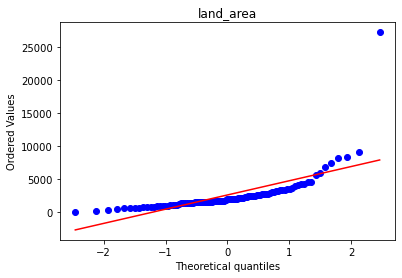

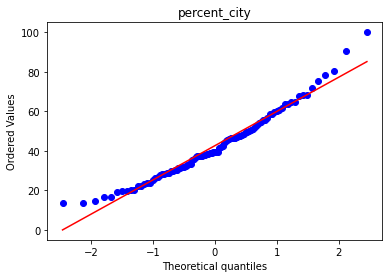

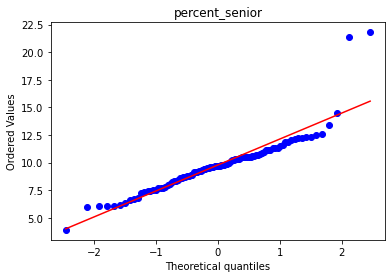

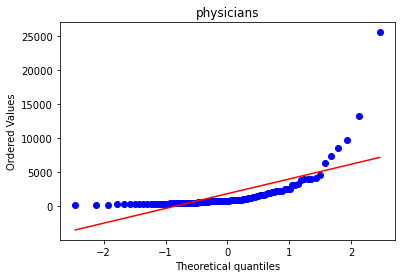

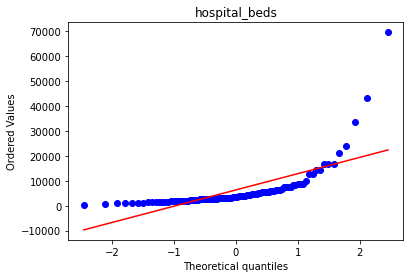

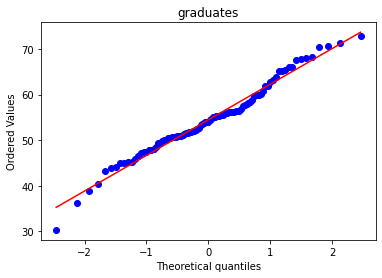

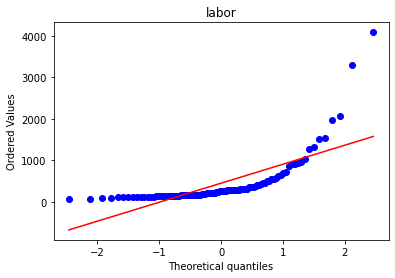

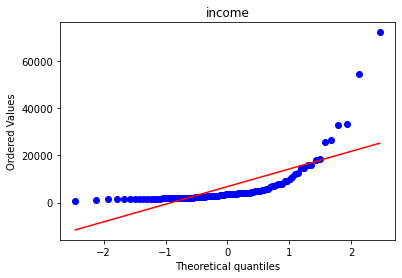

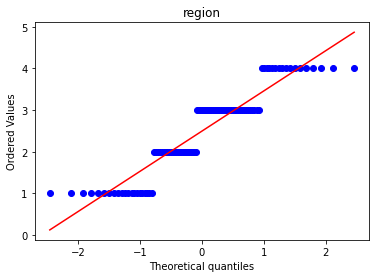

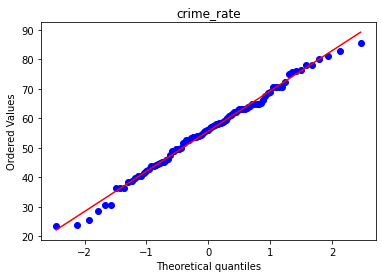

In [43]:
#look at the qq plot of features to check normality of original train data
for c in train.columns:
    stats.probplot(train[c], dist="norm", plot=pylab) 
    plt.title(c)
    plt.show()                #looks pretty normal- workable
                              #some outliers MAY exist- we will deal with that later if needed

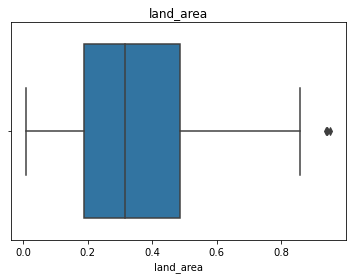

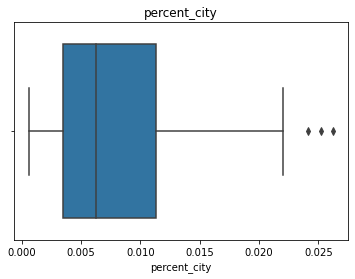

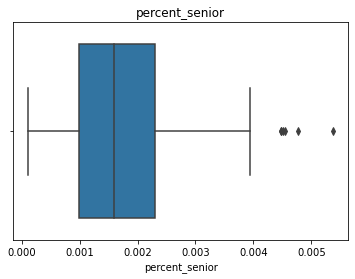

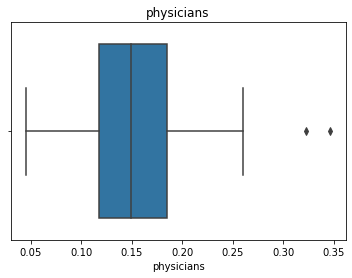

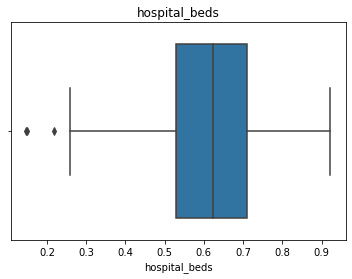

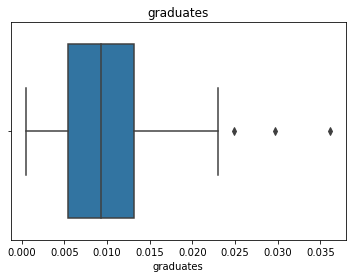

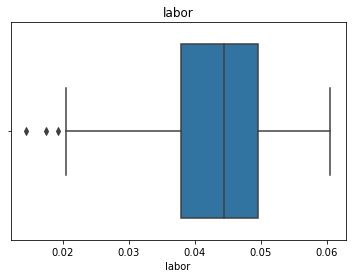

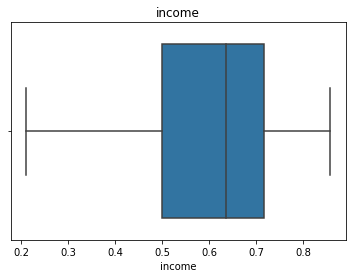

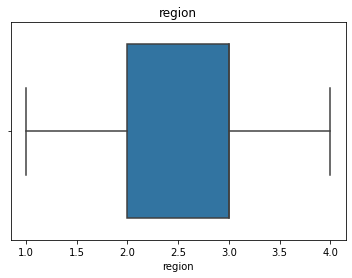

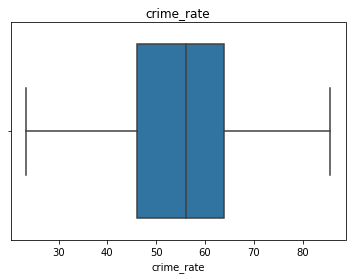

In [7]:
# Boxplot to look at outliers of normalized data
for c in normal_features.columns:
    sns.boxplot(normal_features[c])
    plt.title(c)
    plt.show()
#income, region and crime rate look fine

In [20]:
############################ Remove outliers from normalized data ####################
#define IQR for each feature
IQR = normal_features.quantile(0.75) - normal_features.quantile(0.25) 
IQR
Q1 = normal_features.quantile(0.25)
Q3 = normal_features.quantile(0.75)
#remove data that falls over this boundary of IQR (outliers)
outliers = pd.DataFrame((normal_features < (Q1 - 1.5 * IQR)) |(normal_features > (Q3 + 1.5 * IQR)))

normal_features_out = normal_features[~((normal_features < (Q1 - 1.5 * IQR)) |(normal_features > (Q3 + 1.5 * IQR))).any(axis=1)]

In [22]:
normal_features_out.shape[0] - train.shape[0] #15 rows were removed as outliers

-15

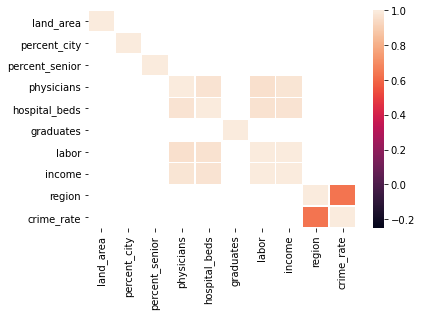

In [33]:
#check out if any features are correlated
sns.heatmap(train.corr(), mask= train.corr() < 0.4, linewidths=.5)  #show strong and medium correlation only

#hospital beds, labor and physicians are highly correlated (close to 1)

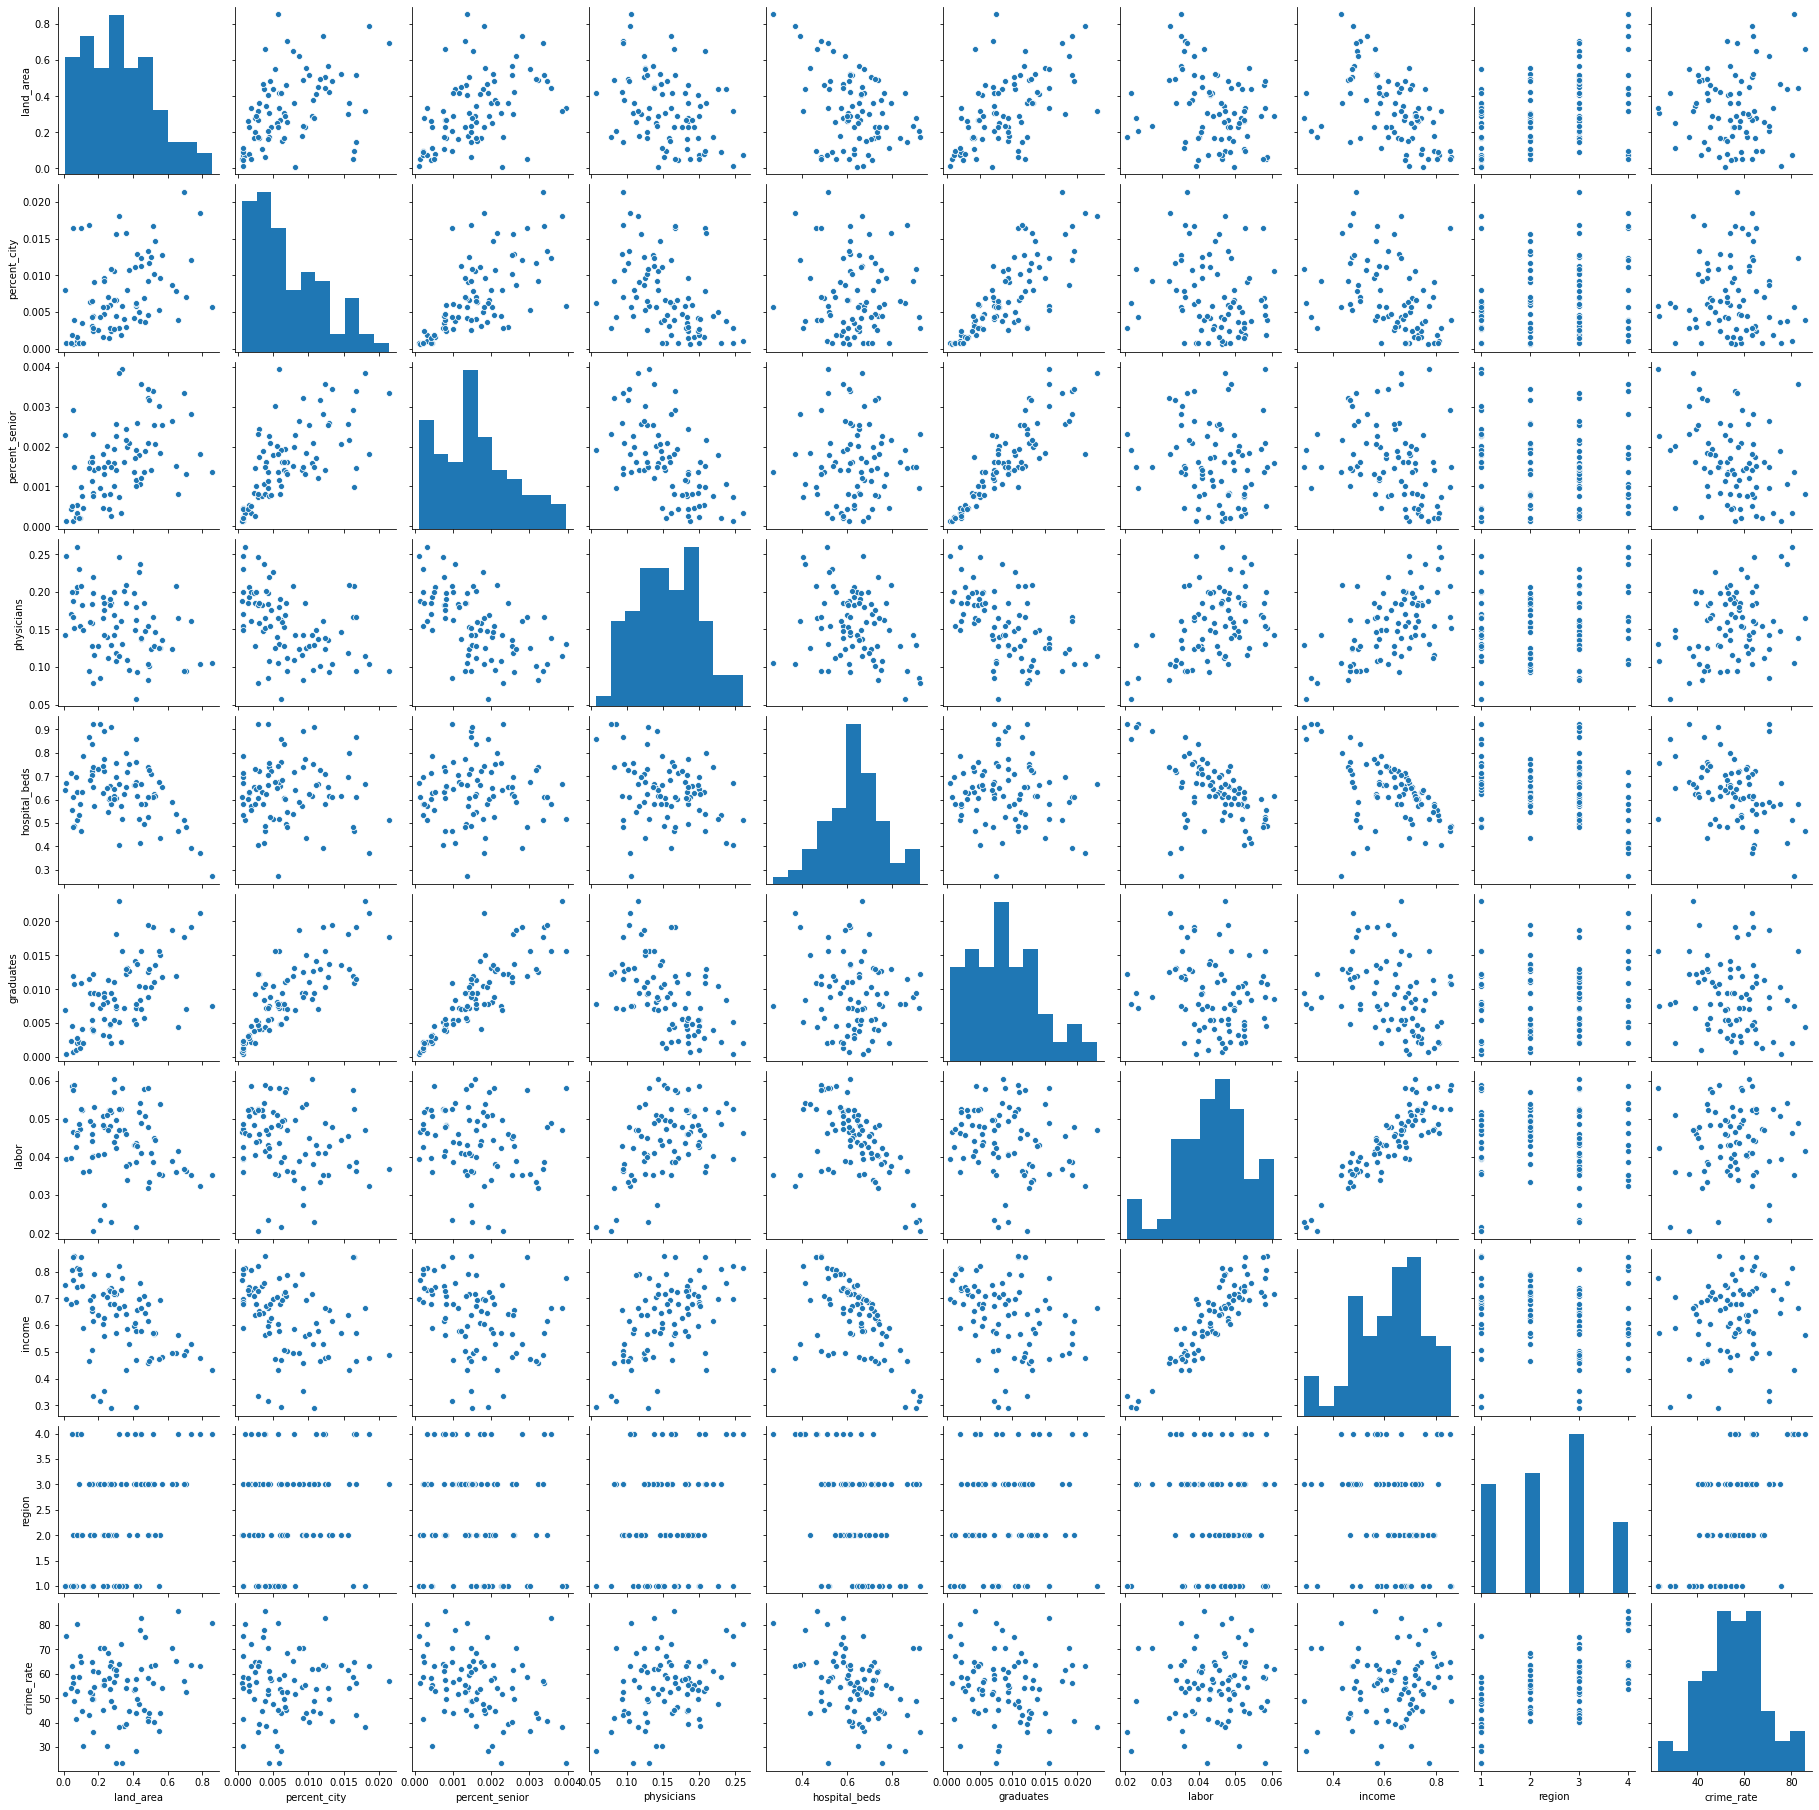

In [23]:
# scatter plot against 'crime_rate' to find nature of dependence
sns.pairplot(normal_features_out)
#No clear Linear pattern of crime rate with other variable
#use non-linear methods

In [ ]:
#use only one of the correlated features - TAKE 'PHYSICIANS'
   #or use PCA

In [33]:
###################### Find BEST features for predictive analysis ################
#recursive feature elimination - RFE

#define our base linear regression model- based on it our features will be selected
basemodel = LinearRegression()

rfe = RFE(basemodel, 5)                 #find top 5 columns-half the feature
fit = rfe.fit(normal_features.iloc[:, 0:-1], normal_features.iloc[:, -1])
print(normal_features.columns[0:-1])
print("Selected Features: %s" % fit.support_)
print(fit.ranking_)

#land_area, hospital beds, labor, income  & region are ranked the lowest- 
    # these are not as important in predicting the crime rates
    
#however we can not completely ignore features as they contribute SOMETHING to our analysis

Index(['land_area', 'percent_city', 'percent_senior', 'physicians',
       'hospital_beds', 'graduates', 'labor', 'income', 'region'],
      dtype='object')
Selected Features: [False  True  True  True False  True  True False False]
[5 1 1 1 2 1 1 3 4]


In [34]:
#so for best model, we use the PCA features and use above features for interpretability only- see which performs best

#PCA
pca = PCA(n_components=5)
pca = pca.fit(normal_features.iloc[:, 0:-1])    #on normalized data to avoid bias

print(pca.explained_variance_ratio_)            #variance of the PCA components obtained in decreasing order


[0.92435502 0.04933952 0.02163542 0.00297113 0.00163368]


In [35]:
pca_features = pd.DataFrame(pca.fit_transform(normal_features.iloc[:, 0:-1]))   #obtain new pca features by transformation 
pca_features.columns = [1, 2, 3, 4, 5]

pca_features['y'] = normal_features.crime_rate
pca_features                                                                     #features used in model below


,1,2,3,4,5,y
0,-1.526435,-0.175695,-0.051742,0.096403,0.060966,75.55
1,-0.528533,-0.265273,-0.116359,0.065115,-0.011623,56.03
2,-1.521072,-0.122593,-0.026951,0.055861,0.024742,41.32
3,-0.523093,-0.226386,-0.152556,0.042773,-0.041211,67.38
4,1.462335,-0.486260,-0.166999,0.084944,0.031737,80.19
...,...,...,...,...,...,...
94,1.531235,0.094443,-0.081775,-0.049012,0.004474,70.66
95,0.580505,0.547423,-0.131327,0.054974,-0.006394,36.36
96,0.522571,0.080359,-0.130390,-0.059372,-0.012482,60.16
97,-1.513601,0.038998,0.379422,0.077277,-0.053907,36.33


In [36]:
#################################### MODEL #######################################

# a) Linear Regression - base model - using PCA features
lg = LinearRegression()
kfold = KFold(10)
rmse = []
# enumerate splits
for train, test in kfold.split(pca_features):
    #print('train: %s, test: %s' % (normal_features.iloc[train, 0:-1], normal_features.iloc[test, 0:-1]))

    lg = lg.fit(pca_features.iloc[train, 0:-1], pca_features.iloc[train, -1])  #fit model
    pred = lg.predict(pca_features.iloc[test, 0:-1])     #5 PCA features passed
    err = mean_squared_error(pca_features.iloc[test, -1], pred)         #y_true, y_pred
    rmse.append(err)
np.mean(rmse)
110.04

110.04

In [37]:
# b) For original normalized training data - LR
lg = LinearRegression()
kfold = KFold(10)
rmse = []
# enumerate splits
for tr, test in kfold.split(normal_features_out):
    lg = lg.fit(normal_features_out.iloc[tr, 0:-1], normal_features_out.iloc[tr, -1])  #fit model
    pred = lg.predict(normal_features_out.iloc[test, 0:-1])     #5 PCA features passed
    err = mean_squared_error(normal_features_out.iloc[test, -1], pred)         #y_true, y_pred
    rmse.append(err)
np.mean(rmse)
#109.88
#So PCA has definitely improved the model

109.88596395515404

In [39]:

#create custom X variables - to remove correlated features from train data (keep physicians)
cols = normal_features_out.columns
X = pd.DataFrame()
for c in cols:
    X[c] = normal_features_out[c]
X = X.drop(['hospital_beds', 'labor', 'land_area'], axis=1)  #drop correlated columns and lowest ranked columns
X.head()


,percent_city,percent_senior,physicians,graduates,income,region,crime_rate
0,0.000754,0.000119,0.247413,0.000484,0.696082,1,75.55
1,0.000618,0.000132,0.187497,0.000758,0.767408,2,56.03
2,0.000771,0.000221,0.200483,0.001043,0.684824,1,41.32
3,0.000719,0.000212,0.154051,0.001256,0.791815,2,67.38
4,0.000964,0.000321,0.260224,0.002023,0.813329,4,80.19


In [40]:
# c) SVR - on PCA data

svm_mod = svm.SVR(kernel='rbf')
#kfold = KFold(10)
rmse = []

# KFOLD takes too long--------------
#for tr, test in kfold.split(X):
  #  svm_mod.fit(X.iloc[tr, 0:-1], X.iloc[tr, -1])
   # pred = svm_mod.predict(X.iloc[test, 0:-1])               
   # err = mean_squared_error(X.iloc[test, -1], pred)         
   # rmse.append(err)
#np.mean(rmse)   #too slow-----------------

svm_mod.fit(pca_features.iloc[0:80, 0:-1], pca_features.iloc[0:80, -1])
pred = svm_mod.predict(pca_features.iloc[80:, 0:-1])               #5 PCA features passed
err = mean_squared_error(pca_features.iloc[80:, -1], pred)
err  
#93.28
#rbf performs best with PCA features

C:\Users\Shruti\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


93.28278112068567

In [41]:
import warnings
warnings.filterwarnings('ignore')

# d) Ridge regression on X
rdg = Ridge()
para = {'alpha': [1e-1, 1e-3, 1e-5, 1e-8, 1e-10, 1e-15, 1, 5, 8, 10, 15]}
grid_ridge = GridSearchCV(rdg, para, scoring = 'neg_mean_squared_error', cv = 10)   #alpha chosen as 1= smoothness

kfold = KFold(10)
rmse = []
# enumerate splits
for tr, test in kfold.split(pca_features):
    grid_ridge.fit(pca_features.iloc[tr, 0:-1],  pca_features.iloc[tr, -1])
    pred = grid_ridge.predict(pca_features.iloc[test, 0:-1])
    err = mean_squared_error(pca_features.iloc[test, -1], pred)
    rmse.append(err)
np.mean(rmse)
#112.22 
# on X data. error = 123
# not better than above models

112.22959445608606

In [42]:
# e) Decision Tree

dt = DecisionTreeRegressor()                    #based on mse for best split

kfold = KFold(10)
rmse = []
# enumerate splits
for tr, test in kfold.split(normal_features_out):
    dt.fit(normal_features_out.iloc[tr, 0:-1],  normal_features_out.iloc[tr, -1])
    pred = dt.predict(normal_features_out.iloc[test, 0:-1])
    err = mean_squared_error(normal_features_out.iloc[test, -1], pred)
    rmse.append(err)
np.mean(rmse)
#193.56 - 
#on pca data it performs even worse

193.5691923611111

In [43]:
####################### look at RESIDUALS for each model for best of fit #####################
#split data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(pca_features.iloc[:, 0:-1], pca_features.iloc[:, -1], test_size = 0.2, random_state=1)


In [44]:
# calculate residuals for our train, test data split above
# a) Linear Regression
lg = LinearRegression()
lg = lg.fit(x_train, y_train)                        
pred = lg.predict(x_test)     
resid_lg = [r for r in y_test- pred]     #calculate residual for each test row
resid_lg

# b) SVR
sv = svm.SVR(kernel='rbf')
sv.fit(x_train, y_train)
pred = sv.predict(x_test)
resid_svr = [r for r in y_test- pred]     #calculate residual for each test row
resid_svr

# c) Ridge Regression
rdg = Ridge()
para = {'alpha': [1e-1, 1e-3, 1e-5, 1e-8, 1e-10, 1e-15, 1, 5, 8, 10, 15]}
grid_ridge = GridSearchCV(rdg, para, scoring = 'neg_mean_squared_error', cv = 10)   

grid_ridge.fit(x_train, y_train)
pred = grid_ridge.predict(x_test)
resid_ridge = [r for r in y_test- pred]     #calculate residual for each test row
resid_ridge

# d) Decision Trees
dt = DecisionTreeRegressor()                    #based on mse for best split
dt.fit(x_train, y_train)
pred = dt.predict(x_test)
resid_dt = [r for r in y_test- pred]     #calculate residual for each test row
resid_dt

[-9.36,
 -9.060000000000002,
 -1.240000000000002,
 0.8299999999999983,
 -32.96,
 -5.609999999999999,
 -14.849999999999994,
 -22.520000000000003,
 19.13,
 9.61,
 -13.219999999999999,
 -12.959999999999994,
 -3.6099999999999994,
 2.4599999999999937,
 1.3799999999999955,
 4.730000000000004,
 -16.959999999999994,
 7.020000000000003,
 2.030000000000001,
 -4.630000000000003]

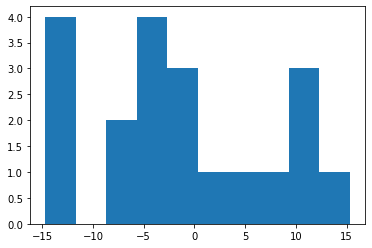

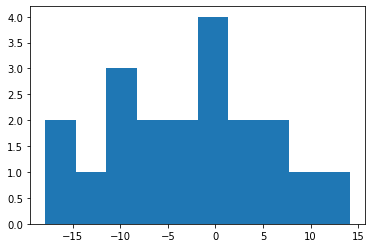

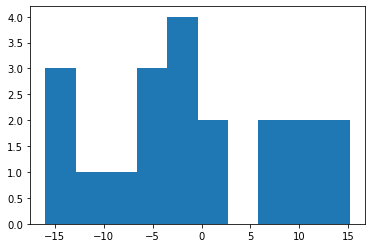

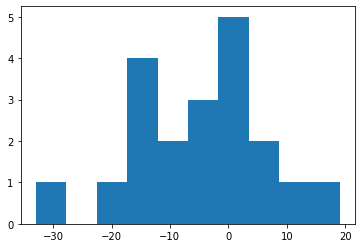

In [45]:
######################### plot residuals ######################
residual_list = [resid_lg, resid_svr, resid_ridge, resid_dt]

# residual histogram
for red in residual_list:
    plt.hist(red)
    plt.show()
    
#only svr model is anything close to a normal (unbiased) distribution

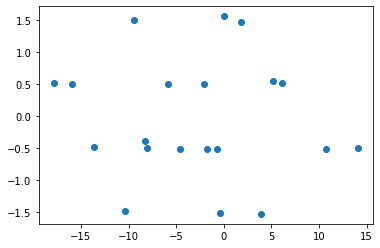

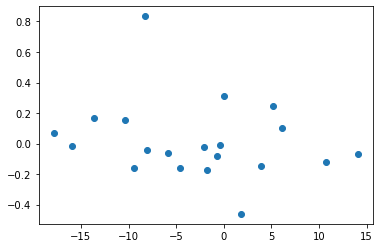

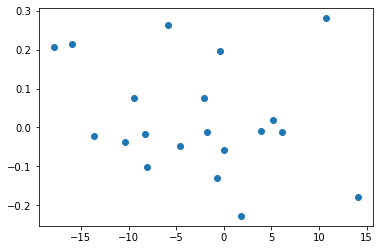

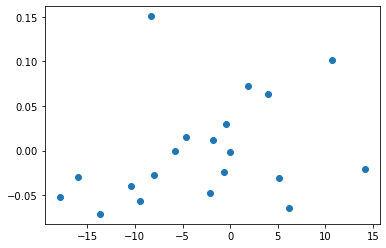

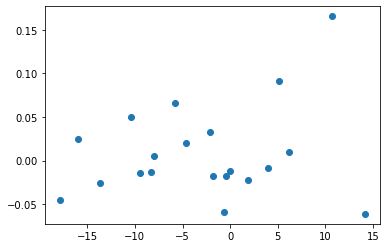

In [46]:
#residual vs test features scatter plot - ONLY for SVR (top candidate)

for c in x_test.columns:
    plt.scatter(resid_svr, x_test[c])
    plt.show()
    
# uniform distribution for svr- 
  # but patterns can be seen which means vital information
    # not included in the model
      # was left out

In [47]:
###################### LOAD test data for final prediction using SVR ##############
test = pd.read_csv("dphi_data_test.csv")
test.shape

(42, 10)

In [48]:
######### Transform test data to resemble our train data that was modeled on ########

# create function for such repeated usage, but for now...
normalized = pd.DataFrame(preprocessing.normalize(test.iloc[:, 0:-2])) #not include 'region'
normalized.columns = test.columns[0:-2]
normalized['region'] = test.region
normalized['crime_rate'] = test.crime_rate
pca = PCA(n_components=5)
pca = pca.fit(normalized.iloc[:, 0:-1])                #include unnormalized 'region'
pca_test = pd.DataFrame(pca.fit_transform(normalized.iloc[:, 0:-1]))   #obtain new pca features by transformation 
pca_test.columns = [1, 2, 3, 4, 5]

pca_test['y'] = normalized.crime_rate
pca_test.head()

#to predict values for the last column (called y here)

,1,2,3,4,5,y
0,-1.240297,-0.253720,-0.101283,-0.041692,0.023722,NaN
1,-1.324006,0.341896,0.029127,0.020747,0.034606,NaN
2,1.697902,0.385325,-0.289059,-0.010023,0.018161,NaN
3,-0.222678,-0.316309,-0.034987,0.049398,0.060991,NaN
4,-0.239491,-0.150506,0.248171,-0.015306,-0.022221,NaN


In [49]:
########### TRAIN SVR for full training data (pca_features) ############
sv_final = svm.SVR(kernel='rbf')
sv_final.fit(pca_features.iloc[:, 0:-1], pca_features.iloc[:, -1])
pred_final = sv_final.predict(pca_test.iloc[:, 0:-1])


In [50]:
test.crime_rate = pred_final
test.head()

,land_area,percent_city,percent_senior,physicians,hospital_beds,graduates,labor,income,region,crime_rate
0,3650,34.6,11.1,2358,6224,62.9,539.3,7792,4,50.688396
1,4883,72.4,7.3,873,2236,64.9,185.2,2353,4,49.583283
2,1435,13.4,11.7,342,1076,44.7,156.8,2165,1,63.173494
3,2042,24.5,16.5,4071,10039,51.9,681.7,10166,3,55.493582
4,1630,41.9,10.7,724,4395,50.0,198.0,2445,3,54.939446


In [142]:
# put into csv
test.to_csv('dphi_test_predictions.csv')


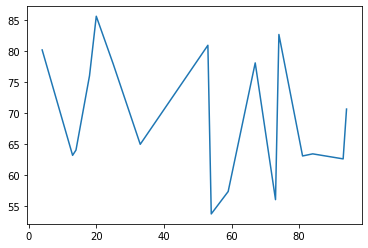

In [53]:
####################  rough plotting to see prediction quality ###########
plt.plot(train.crime_rate[train.region == 4])

#reload train data if error

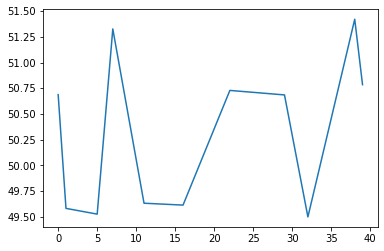

In [54]:
plt.plot(test.crime_rate[test.region == 4])

######################## Rough work ###########################
#                       XXXXXXXXXXXXX  